### pycwt tutorial
##### [link](https://pycwt.readthedocs.io/en/latest/tutorial.html)

#### Modules

In [1]:
from __future__ import division
import numpy
from matplotlib import pyplot

In [2]:
import pycwt as wavelet
from pycwt.helpers import find

#### Load data

In [3]:
url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
dat = numpy.genfromtxt(url, skip_header=19)
title = 'NINO3 Sea Surface Temperature'
label = 'NINO3 SST'
units = 'degC'
t0 = 1871.0
dt = 0.25  # In years

In [5]:
# Create time array in years
N = dat.size
t = numpy.arange(0, N) * dt + t0

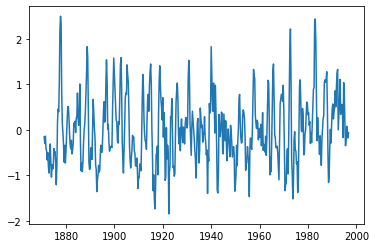

In [6]:
pyplot.plot(t, dat)

In [9]:
# Detrend data
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()
var = std ** 2
dat_norm = dat_notrend / std

<b> Parameters for wavelet analysis </b>

In [11]:
mother = wavelet.Morlet(6) # Morlet with omega0 = 6
s0 = 2 * dt # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12 # Twelve sub-octaves per octave
J = 7 / dj # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat) # Lag-1 autocorrelation for red noise

<p><b>Wavelet transform and inverse wavelet transform</b></p>
<p><b>NB</b>: Because the input series is normalized we have to multiply inverse transform by the standard deviation</p>

In [13]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [19]:
# compute normalized wavelet and fourier power spectra, as well as 
# equivalent periods for each wavelet scale
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [20]:
# (optional) power spectra rectification proposed by Liu et al. 2007
power /= scales[:, None]

In [21]:
# Power spectra significance test: power is significant where power / sig95 > 1
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [23]:
# Compute global wavelet spectrum
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [24]:
# Compute scale average between 2 and 8 years and significance level
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

<p>Plot our results in four different subplots containing the (i) original series anomaly and the inverse wavelet transform; (ii) the wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and (iv) the range averaged wavelet spectrum. In all sub-plots the significance levels are either included as dotted lines or as filled contour lines.</p>

/Users/Cisco/anaconda3/envs/WVLT/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


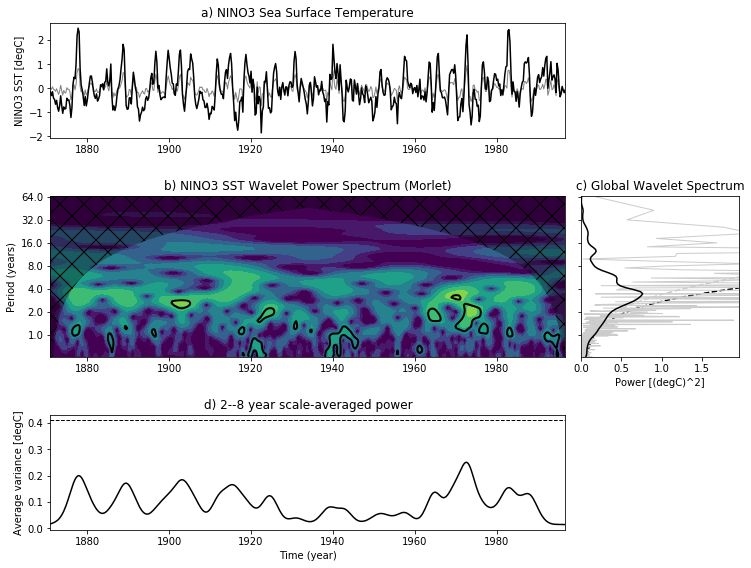

In [25]:
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

/Users/Cisco/anaconda3/envs/WVLT/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'NINO3 SST [degC]')

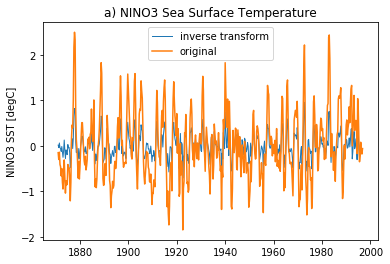

<Figure size 576x576 with 0 Axes>

In [35]:
# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
fig, ax = pyplot.subplots()
pyplot.figure(figsize=(8,8))
ax.plot(t, iwave, '-', linewidth=1, label="inverse transform")
ax.plot(t, dat, linewidth=1.5, label="original")
ax.legend()
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))